In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.text import TextPath
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# from sklearn.pipeline import make_pipeline
# import seaborn as sns
# from tqdm import tqdm

In [2]:
cols = {'ANA':'#b85e0b','ARI':'#7d1db3','BOS':'#ffec00','BUF':'#b653fb','CAR':'#963e3e','CBJ':'#475483','CGY':'#b45300','CHI':'#8d6b0a','COL':'#6b051f','DAL':'#007f16','DET':'#ff0000','EDM':'#352247','FLA':'#77d200','LAK':'#380078','MIN':'#003a07','MTL':'#ec0365','NJD':'#ab0027','NSH':'#f3bf00','NYI':'#0078ff','NYR':'#07b182','OTT':'#805700','PHI':'#ff7c00','PIT':'#19bcd1','SEA':'#00c9b5','SJS':'#016072','STL':'#000df0','TBL':'#150078','TOR':'#363caf','VAN':'#5c6c98','VGK':'#bca900','WPG':'#140e6b','WSH':'#990276'}

In [3]:
pbp20 = pd.read_csv('nhl_pbp_20202021.csv')
# toi19 = pd.read_csv('nhl_shifts_20192020.csv')
pbp19 = pd.read_csv('nhl_pbp_20192020.csv')
# toi18 = pd.read_csv('nhl_shifts_20182019.csv')
pbp18 = pd.read_csv('nhl_pbp_20182019.csv')
# toi17 = pd.read_csv('nhl_shifts_20172018.csv')
pbp17 = pd.read_csv('nhl_pbp_20172018.csv')

In [4]:
# toi_table = toi20.append(toi19).append(toi18).append(toi17)
pbp_table = pbp20.append(pbp19).append(pbp18).append(pbp17)

In [5]:
events = [e for e in pbp_table['Event'] if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
descriptions = [d for e, d in zip(pbp_table['Event'], pbp_table['Description']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
strength = [s for e, s in zip(pbp_table['Event'], pbp_table['Strength']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
xcoord = [x for e, x in zip(pbp_table['Event'], pbp_table['xC']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
ycoord = [y for e, y in zip(pbp_table['Event'], pbp_table['yC']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
per_time = [t for e, t in zip(pbp_table['Event'], pbp_table['Time_Elapsed']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
per = [p for e, p in zip(pbp_table['Event'], pbp_table['Period']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
secs = [s for e, s in zip(pbp_table['Event'], pbp_table['Seconds_Elapsed']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
# since_last = [s for e, s in zip(pbp_table['Event'], pbp_table['Seconds_Since']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
zone = [z for e, z in zip(pbp_table['Event'], pbp_table['Ev_Zone']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
shot_type = [t for e, t in zip(pbp_table['Event'], pbp_table['Type']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
indices = range(len(pbp_table['Event']))
prev_event = [pbp_table['Event'].iloc[i-1] for e, i in zip(pbp_table['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
prev_x = [pbp_table['xC'].iloc[i-1] for e, i in zip(pbp_table['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
prev_y = [pbp_table['yC'].iloc[i-1] for e, i in zip(pbp_table['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']

In [6]:
since_last = [s-secs[l-1] if s>=secs[l-1] else -1 for s,l in zip(secs,range(len(secs)))]

In [ ]:
strength_dict = {'0x5': 0, '5x6': 1, '5x2': 2, '4x4': 3, '5x3': 4, '5x1': 5, '4x3': 6, '4x6': 7, '6x6': 8, '5x0': 9, '4x5': 10, '6x1': 11, '5x7': 12, '5x4': 13, '1x5': 14, '2x5': 15, '3x5': 16, '2x3': 17, '0x0': 18, '1x1': 19, '1x0': 20, '8x5': 21, '-1x0': 22, '0x1': 23, '-1x-1': 24, '6x5': 25, '4x2': 26, '2x4': 27, '3x4': 28, '3x3': 29, '5x5': 30}
shot_type_dict = {'TIP-IN': 1, 'DEFLECTED': 2, 'WRIST SHOT': 3, 'SLAP SHOT': 4, 'SNAP SHOT': 5, 'BACKHAND': 6, 'WRAP-AROUND': 7}
prev_event_dict = {'MISS': 0, 'GIVE': 1, 'CHL': 2, 'SHOT': 3, 'GOAL': 4, 'STOP': 5, 'GEND': 6, 'FAC': 7, 'BLOCK': 8, 'HIT': 9, 'PENL': 10, 'TAKE': 11, 'DELPEN': 12, 'PSTR': 13, 'PEND': 14, 'EISTR': 15}

In [7]:
# setting up categorical-->numerical variables
strength_unique = list(set(strength))
strength_dict = dict(zip(strength_unique,range(len(strength_unique))))
strength_nums = [strength_dict[x] for x in strength]

zone_unique = list(set(zone))
zone_dict = dict(zip(zone_unique,range(len(zone_unique))))
zone_nums = [zone_dict[x] for x in zone]

shot_type_unique = list(set(shot_type))
shot_type_dict = dict(zip(shot_type_unique,range(len(shot_type_unique))))
shot_type_nums = [shot_type_dict[x] for x in shot_type]

prev_event_unique = list(set(prev_event))
prev_event_dict = dict(zip(prev_event_unique,range(len(prev_event_unique))))
prev_event_nums = [prev_event_dict[x] for x in prev_event]

In [8]:
goal_state = [1 if e == 'GOAL' else 0 for e in events]

In [9]:
forest = RandomForestRegressor(random_state=0)

In [10]:
features = np.array((strength_nums, xcoord, ycoord, per, secs, since_last, 
                     zone_nums, shot_type_nums, prev_event_nums, prev_x, prev_y))
feature_names = ['Strength', 'xC', 'yC', 'Period', 'Seconds into period', 'Seconds since last event', 'Zone',
                 'Shot type', 'Previous event', 'Previous xC', 'Previous yC']

In [11]:
features

array([[ 30.,  30.,  30., ...,  30.,  30.,  30.],
       [-74.,  49., -52., ..., -70.,  74.,  79.],
       [ 29., -25., -31., ...,  -2.,   1., -14.],
       ...,
       [  7.,   8.,   9., ...,   3.,   8.,   3.],
       [  0., -58., -87., ..., -56.,  62.,  74.],
       [  0.,  -7., -33., ...,  -1.,  17.,   1.]])

In [12]:
features[np.isnan(features)] = 0

In [13]:
forest.fit(features.T, goal_state)

RandomForestRegressor(random_state=0)

In [14]:
importances = forest.feature_importances_

In [15]:
for i, val in enumerate(feature_names):
    print(f'{val}: {importances[i]}')

Strength: 0.024718548971414515
xC: 0.12168486155775617
yC: 0.1133535697013977
Period: 0.040536258365184555
Seconds into period: 0.19949814876564279
Seconds since last event: 0.14573501477044484
Zone: 0.005391873141121684
Shot type: 0.03589210967602305
Previous event: 0.04657377435205213
Previous xC: 0.13892593967159578
Previous yC: 0.12768990102736694


In [16]:
def xG(s, xC, yC, p, sinp, ssle, st, pe, pxC, pyC):
    return importances[0]*s + importances[1]*xC + importances[2]*yC + importances[3]*p + importances[4]*sinp + importances[5]*ssle + importances[6]*st + importances[7]*pe + importances[8]*pxC + importances[9]*pyC


In [34]:
joblib.dump(forest, 'fearfactorxg.joblib')

['fearfactorxg.joblib']

# ok let's test it

In [18]:
p_pbp = pd.read_csv('./gamestats/csvs/nhl_pbp_1651341935.csv')

In [19]:
events = [e for e in p_pbp['Event'] if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
event_team = [t for e, t in zip(p_pbp['Event'], p_pbp['Ev_Team']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
descriptions = [d for e, d in zip(p_pbp['Event'], p_pbp['Description']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
strength = [s for e, s in zip(p_pbp['Event'], p_pbp['Strength']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
xcoord = np.asarray([x for e, x in zip(p_pbp['Event'], p_pbp['xC']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS'])
ycoord = np.asarray([y for e, y in zip(p_pbp['Event'], p_pbp['yC']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS'])
per_time = [t for e, t in zip(p_pbp['Event'], p_pbp['Time_Elapsed']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
per = [p for e, p in zip(p_pbp['Event'], p_pbp['Period']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
secs = [s for e, s in zip(p_pbp['Event'], p_pbp['Seconds_Elapsed']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
zone = [z for e, z in zip(p_pbp['Event'], p_pbp['Ev_Zone']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
shot_type = [t for e, t in zip(p_pbp['Event'], p_pbp['Type']) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
indices = range(len(p_pbp['Event']))
prev_event = [p_pbp['Event'].iloc[i-1] for e, i in zip(p_pbp['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS']
prev_x = np.asarray([p_pbp['xC'].iloc[i-1] for e, i in zip(p_pbp['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS'])
prev_y = np.asarray([p_pbp['yC'].iloc[i-1] for e, i in zip(p_pbp['Event'], indices) if e == 'GOAL' or e == 'SHOT' or e == 'MISS'])

In [20]:
xcoord[np.isnan(xcoord)] = 0
ycoord[np.isnan(ycoord)] = 0
prev_x[np.isnan(prev_x)] = 0
prev_y[np.isnan(prev_y)] = 0

In [21]:
since_last = [s-secs[l-1] if s>=secs[l-1] else -1 for s,l in zip(secs,range(len(secs)))]

In [22]:
# setting up categorical-->numerical variables
strength_unique = list(set(strength))
# strength_dict = dict(zip(strength_unique,range(len(strength_unique))))
strength_nums = [strength_dict[x] for x in strength]

zone_unique = list(set(zone))
# zone_dict = dict(zip(zone_unique,range(len(zone_unique))))
zone_nums = [zone_dict[x] for x in zone]

shot_type_unique = list(set(shot_type))
# shot_type_dict = dict(zip(shot_type_unique,range(len(shot_type_unique))))
shot_type_nums = [shot_type_dict[x] for x in shot_type]

prev_event_unique = list(set(prev_event))
# prev_event_dict = dict(zip(prev_event_unique,range(len(prev_event_unique))))
prev_event_nums = [prev_event_dict[x] for x in prev_event]

In [23]:
all_xg = forest.predict(np.array((strength_nums, xcoord, ycoord, per, secs, since_last, zone_nums,
              shot_type_nums, prev_event_nums, prev_x, prev_y)).T)

In [24]:
all_xg

array([0.02, 0.21, 0.22, 0.26, 0.05, 0.18, 0.05, 0.02, 0.  , 0.03, 0.  ,
       0.03, 0.02, 0.07, 0.27, 0.04, 0.16, 0.07, 0.  , 0.07, 0.16, 0.18,
       0.  , 0.16, 0.07, 0.01, 0.12, 0.2 , 0.  , 0.18, 0.02, 0.  , 0.03,
       0.03, 0.03, 0.05, 0.05, 0.  , 0.15, 0.34, 0.04, 0.5 , 0.02, 0.13,
       0.06, 0.  , 0.05, 0.16, 0.01, 0.03, 0.01, 0.03, 0.07, 0.02, 0.07,
       0.23, 0.04, 0.14, 0.  , 0.05, 0.02, 0.09, 0.05, 0.11, 0.01, 0.1 ,
       0.18, 0.01, 0.09, 0.12, 0.02, 0.29, 0.01, 0.14, 0.02, 0.07, 0.04,
       0.17, 0.32, 0.27, 0.01, 0.21, 0.02, 0.13, 0.17, 0.23, 0.3 , 0.12,
       0.61, 0.35, 0.59, 0.32, 0.28, 0.15])

In [25]:
# setting up data for plotting
per = np.asarray(per)

xc_plot = [x if p%2==0 else -x for x, p in zip(xcoord,per)]
xc_plot = np.asarray(xc_plot)

yc_plot = [y if p%2==0 else -y for y, p in zip(ycoord,per)]
yc_plot = np.asarray(yc_plot)

event_team = np.asarray(event_team)
events = np.asarray(events)
all_xg = np.asarray(all_xg)
descriptions = np.asarray(descriptions)
strength = np.asarray(strength)

In [26]:
angles = np.degrees(np.arctan((xc_plot)/yc_plot))
angles[np.isnan(angles)] = 0

/tmp/ipykernel_31440/2701399205.py:1: RuntimeWarning: divide by zero encountered in true_divide
  angles = np.degrees(np.arctan((xc_plot)/yc_plot))


In [27]:
# marks = [(3,0,a) if t=='VGK' else (2,0,a) for a, t in zip(angles, event_team)]
marks = [(3,0,a+90) if y>=0 and t=='VGK' else (3,0,a-90) if  y>=0 else (3,0,a) for a, t, y in zip(angles, event_team, yc_plot)]
marks = np.asarray(marks)

<IPython.core.display.Javascript object>


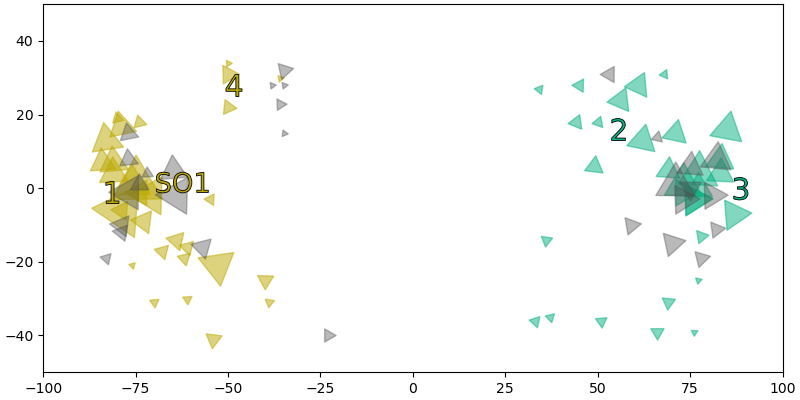

1 - Howden (0.27 xG)
2 - Zibanejad (0.00 xG)
3 - Kreider PPG (0.50 xG)
4 - Coghlan (0.01 xG)
SO1 - Marchessault (0.28 xG)


[(-100.0, 100.0), (-50.0, 50.0)]

In [29]:
%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(8,4), constrained_layout=True)

for i in range(len(xc_plot[events=='SHOT'])):
    ax.scatter(xc_plot[events=='SHOT'][i],
               yc_plot[events=='SHOT'][i], 
               s=(all_xg[events=='SHOT'][i]+0.01)*3000,
               c=cols[event_team[events=='SHOT'][i]], 
               alpha=0.5, marker=marks[events=='SHOT'][i])

for i in range(len(xc_plot[events=='MISS'])):
    ax.scatter(xc_plot[events=='MISS'][i],
               yc_plot[events=='MISS'][i], 
               s=(all_xg[events=='MISS'][i]+0.01)*3000,
               c='#525252', 
               alpha=0.4, marker=marks[events=='MISS'][i])

for g in range(len(xc_plot[(events=='GOAL')])):
    
    so_increment = 1
    
    scorer = descriptions[events=='GOAL'][g].split(' ')[2]
    if '(' in scorer:
        scorer = scorer.split('(')[0].capitalize()
    else:
        scorer = scorer.split(',')[0].capitalize()
    
    if per[events=='GOAL'][g] == 4:
        mark = 'OT'
        msize = 6000
    elif per[events=='GOAL'][g] == 5:
        mark = 'SO' + f'{so_increment}'
        so_increment += 1
        msize = 6000
    else:
        mark = g+1
        msize = 1000
        
    strstr1 = int(strength[events=='GOAL'][g].split('x')[0])
    strstr2 = int(strength[events=='GOAL'][g].split('x')[1])
    if strstr1 > strstr2:
        stren = ' PPG'
    elif strstr1 < strstr2:
        stren = ' SHG'
    else:
        stren = ''
        
    textmark = TextPath((0,0), str(mark))
        
    ax.scatter(xc_plot[events=='GOAL'][g],
           yc_plot[events=='GOAL'][g], 
#            s=(all_xg[events=='GOAL'][g]+0.01)*1750,
           c=cols[event_team[events=='GOAL'][g]],
           edgecolor='k', linewidth=0.6,
           marker=textmark, s=msize)
    
    xgh = all_xg[events=='GOAL'][g]
    print(f'{str(mark)} - {scorer}{stren} ({xgh:.2f} xG)')
    
ax.set(xlim=(-100,100), ylim=(-50,50))